<a href="https://colab.research.google.com/github/ojaashampiholi/Techpoint-Covid19/blob/dev/TechPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         _id COUNTY_NAME  ... COVID_DEATHS  COVID_TEST
0          1       ADAMS  ...            0           0
1          2       ADAMS  ...            0           0
2          3       ADAMS  ...            0           0
3          4       ADAMS  ...            0           0
4          5       ADAMS  ...            0           1
...      ...         ...  ...          ...         ...
11771  11772     WHITLEY  ...            1          26
11772  11773     WHITLEY  ...            0          16
11773  11774     WHITLEY  ...            0           9
11774  11775     WHITLEY  ...            0           1
11775  11776     WHITLEY  ...            0           3

[11776 rows x 6 columns]
['ADAMS' 'ALLEN' 'BARTHOLOMEW' 'BENTON' 'BLACKFORD' 'BOONE' 'BROWN'
 'CARROLL' 'CASS' 'CLARK' 'CLAY' 'CLINTON' 'CRAWFORD' 'DAVIESS' 'DEARBORN'
 'DECATUR' 'DEKALB' 'DELAWARE' 'DUBOIS' 'ELKHART' 'FAYETTE' 'FLOYD'
 'FOUNTAIN' 'FRANKLIN' 'FULTON' 'GIBSON' 'GRANT' 'GREENE' 'HAMILTON'
 'HANCOCK' 'HARRISON' 'HENDRICKS' 

Counties Data Forecasting

In [110]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Bidirectional
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.backend import clear_session
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [111]:
# url = 'https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv?raw=true'

# df = pd.read_csv(url)
# df = df[df['state']=='Indiana']
# df = df[['date', 'county', 'cases', 'deaths']]
# df

# url = 'https://hub.mph.in.gov/datastore/dump/afaa225d-ac4e-4e80-9190-f6800c366b58?bom=True'  
# X = pd.read_csv(url, index_col=[2], 
#     parse_dates=[2])
# featureColumns = ['COUNTY_NAME', 'COVID_COUNT', 'COVID_DEATHS', 'COVID_TEST']
# X = X[featureColumns]

url = 'https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv?raw=true'
df = pd.read_csv(url, parse_dates=[0])
df = df[df['state']=='Indiana']
df['county'] = df['county'].str.lower()
df = df[['date', 'county', 'cases', 'deaths']]

url2 = 'https://hub.mph.in.gov/datastore/dump/afaa225d-ac4e-4e80-9190-f6800c366b58?bom=True'  
X = pd.read_csv(url2, parse_dates=[2])
featureColumns = ['DATE', 'COUNTY_NAME', 'COVID_TEST']
X = X[featureColumns]
X['COUNTY_NAME'] = X['COUNTY_NAME'].str.lower()
X = X.rename(columns={"DATE": "date", "COUNTY_NAME": "county", "COVID_TEST":"new test"})

combinedData = df.merge(X, on=['date', 'county'])
combinedData

,date,county,cases,deaths,new test
0,2020-03-06,marion,1,0,1
1,2020-03-07,marion,1,0,2
2,2020-03-08,hendricks,1,0,0
3,2020-03-08,marion,1,0,3
4,2020-03-09,hendricks,2,0,0
...,...,...,...,...,...
9566,2020-07-06,washington,67,1,0
9567,2020-07-06,wayne,318,6,0
9568,2020-07-06,wells,90,1,1
9569,2020-07-06,white,265,10,0


In [112]:
def windowData(training_scaled, n_len):
  x_train = []
  y_train = []
  for i in range(n_len,training_scaled.shape[0]):
    x_train.append(training_scaled[i-n_len:i, :])
    y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  #print(x_train.shape, y_train.shape)
  return x_train,y_train

In [114]:
def processData(df, n_len = 15):
  counties = df['county'].unique()
  trainX = np.random.randn(1,n_len, 3)
  trainY = np.random.randn(1,3)
  #print(trainX, trainY)
  tempX = []
  tempY = []
  for county in counties:
    df1 = df[df['county']==county]
    if df1.shape[0]<80:
      continue
    df2 = df1[['cases', 'deaths', 'new test']]
    #df2 = df2.diff(periods=1)
    #print(df2)
    df2 = df2.values
    tempX, tempY = windowData(df2, n_len)
    trainX = np.concatenate((trainX, tempX), axis = 0)
    trainY = np.concatenate((trainY, tempY), axis = 0)

  trainX , trainY = trainX[1:,:,:] ,  trainY[1:,:]
  return trainX , trainY

trainX , trainY = processData(combinedData, 15)
print("After Preprocessing the data")
print(trainX.shape, trainY.shape)
batchSize = 512

After Preprocessing the data
(8206, 15, 3) (8206, 3)


In [124]:
clear_session()

regressor = Sequential()
regressor.add(LSTM(units = batchSize,return_sequences = True,input_shape = (trainX.shape[1],trainX.shape[2])))
regressor.add(LSTM(units = 500,return_sequences = True))
regressor.add(LSTM(units = 500,return_sequences = True))
regressor.add(LSTM(units = 250,return_sequences = False))
# regressor.add(Dense(units = 128, activation = 'relu'))
# regressor.add(Dropout(0.15))
regressor.add(Dense(units = 256, activation = 'relu'))
regressor.add(Dropout(0.15))
regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.1))
regressor.add(Dense(units = 64, activation = 'relu'))
regressor.add(Dropout(0.05))
regressor.add(Dense(units = 3))

regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 512)           1056768   
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 500)           2026000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 500)           2002000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 250)               751000    
_________________________________________________________________
dense (Dense)                (None, 256)               64256     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [133]:
#regressor.fit(trainX,trainY,epochs = 500, batch_size = batchSize)
new_regressor.fit(trainX,trainY,epochs = 100, batch_size = batchSize)

Epoch 1/100
17/17 [==============================] - 2s 99ms/step - loss: 26.4490
Epoch 2/100
17/17 [==============================] - 2s 99ms/step - loss: 25.7377
Epoch 3/100
17/17 [==============================] - 2s 100ms/step - loss: 23.7440
Epoch 4/100
17/17 [==============================] - 2s 100ms/step - loss: 41.9894
Epoch 5/100
17/17 [==============================] - 2s 99ms/step - loss: 28.0002
Epoch 6/100
17/17 [==============================] - 2s 99ms/step - loss: 23.2808
Epoch 7/100
17/17 [==============================] - 2s 99ms/step - loss: 23.8261
Epoch 8/100
17/17 [==============================] - 2s 100ms/step - loss: 24.3928
Epoch 9/100
17/17 [==============================] - 2s 100ms/step - loss: 24.0849
Epoch 10/100
17/17 [==============================] - 2s 99ms/step - loss: 22.6476
Epoch 11/100
17/17 [==============================] - 2s 100ms/step - loss: 22.5443
Epoch 12/100
17/17 [==============================] - 2s 100ms/step - loss: 22.8440
Epoch 1

In [134]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/checkpoint.h5"
#regressor.save(path) 
new_regressor.save(path)

In [135]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/checkpoint.h5"
new_regressor= load_model(path)

In [136]:
def processValData(training_scaled, n_len = 15):
  x_train = []
  y_train = []
  for i in range(n_len,len(training_scaled)):
      x_train.append(training_scaled[i-n_len:i, :])
      y_train.append(training_scaled[i,:])

  x_train,y_train = np.array(x_train),np.array(y_train)
  return x_train,y_train

Image saved to drive


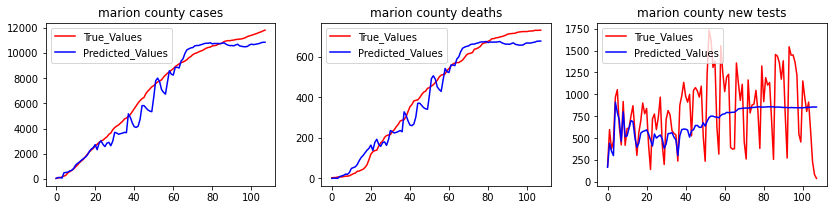

In [146]:
def validationResults(df,  n_len = 15, n_counties = 10, drawGraphs = False, formatType = 'jpg'):
    counties = df['county'].unique()
    my_path = f"{os.getcwd()}/drive/My Drive/Techpoint/"
    for county in counties[:n_counties]:
        df3 = df[df['county']==county]
        if df3.shape[0]<80:
            continue
        df3 = df3[['cases', 'deaths', 'new test']]
        df3 = df3.iloc[:,:].values
        testX, testY = processValData(df3, n_len)
        predictedValues = new_regressor.predict(testX)
        for i in range(predictedValues.shape[0]):
            for j in range(predictedValues.shape[1]):
                predictedValues[i,j] = int(predictedValues[i,j])
        
        if drawGraphs:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,3))
            ax1.plot(testY[:,0],color = 'red', label = 'True_Values')
            ax1.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
            ax1.set_title(county + ' county cases')
            ax1.legend()
            ax2.plot(testY[:,1],color = 'red', label = 'True_Values')
            ax2.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
            ax2.set_title(county + ' county deaths')
            ax2.legend()
            ax3.plot(testY[:,2],color = 'red', label = 'True_Values')
            ax3.plot(predictedValues[:,2], color = 'blue', label = 'Predicted_Values')
            ax3.set_title(county + ' county new tests')
            ax3.legend()
            if formatType == 'jpeg' or 'jpg':
                plt.savefig(my_path + str(county) + '.jpg')
            if formatType == 'png':
                plt.savefig(my_path + str(county) + '.png')

validationResults(combinedData, 15, 1, True)

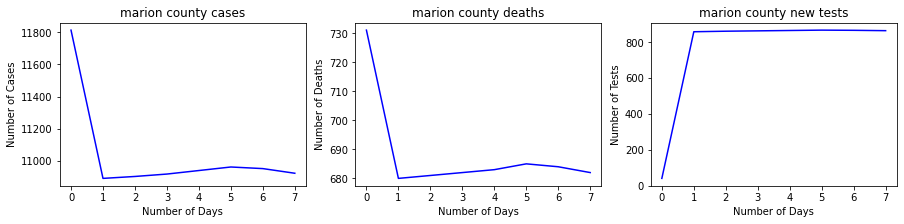

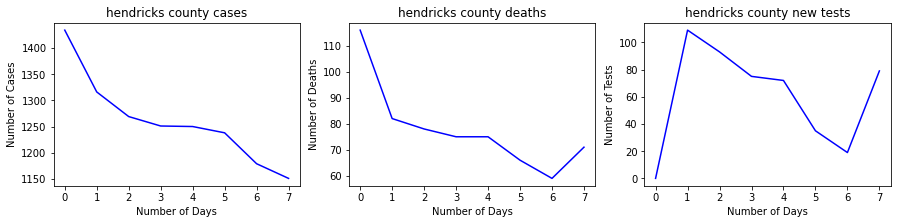

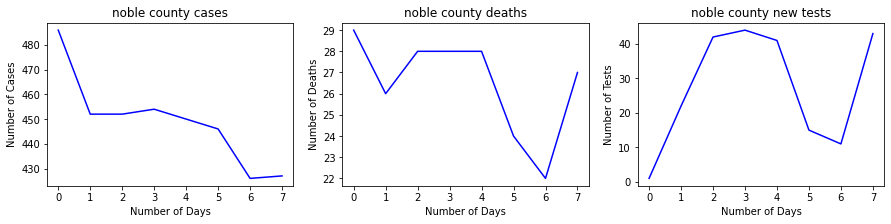

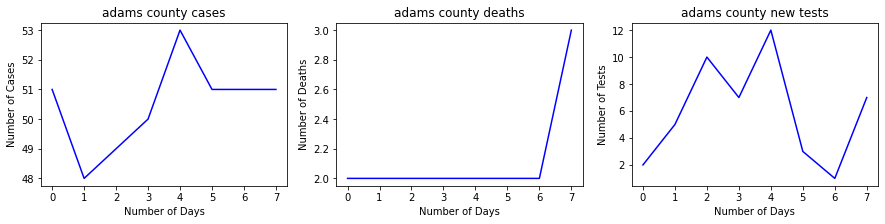

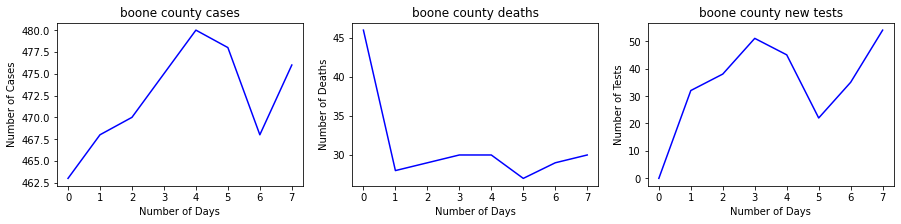

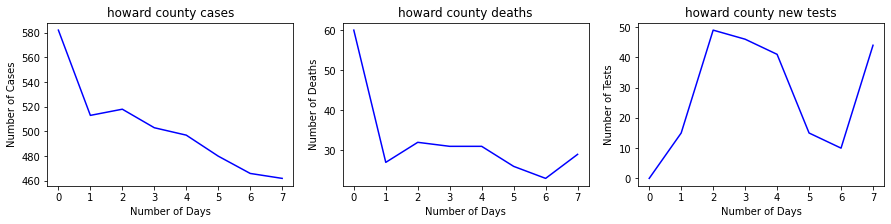

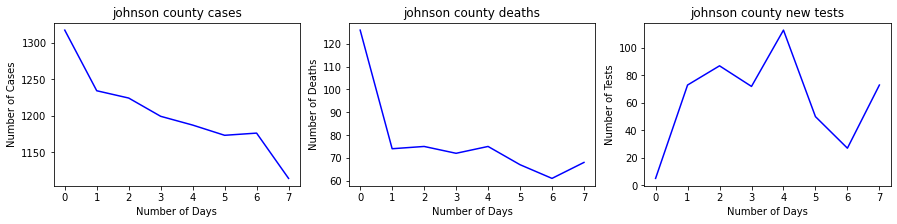

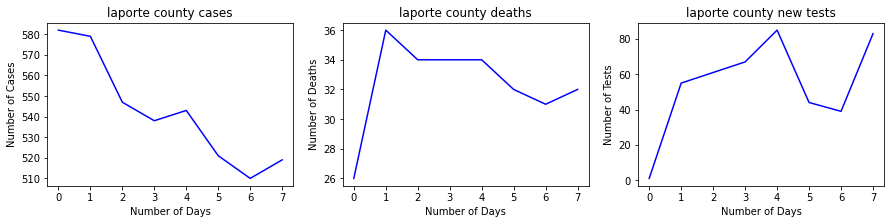

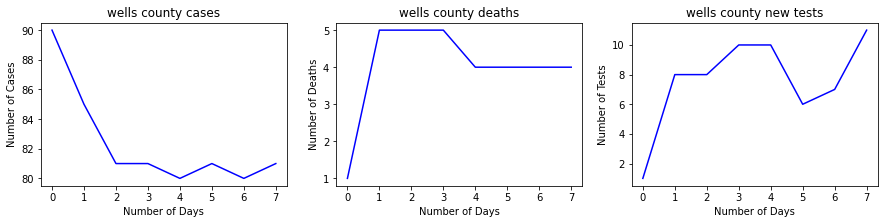

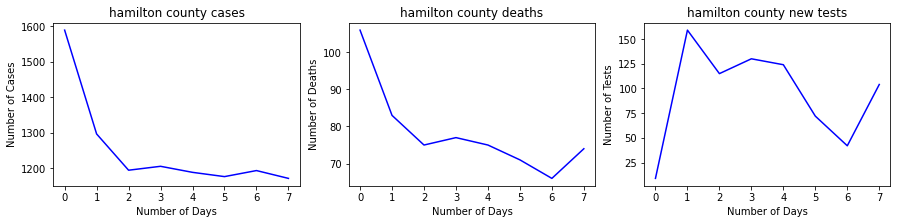

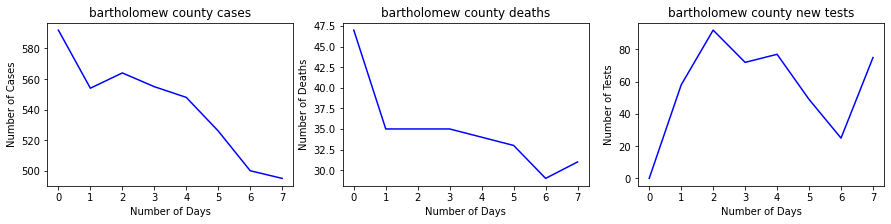

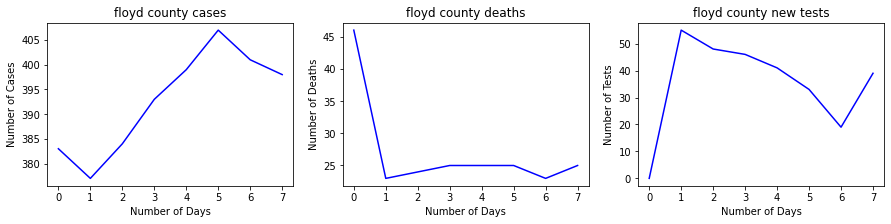

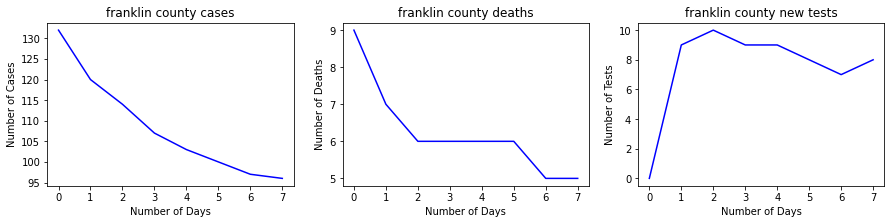

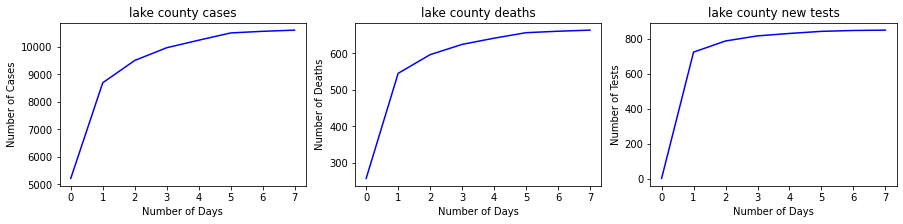

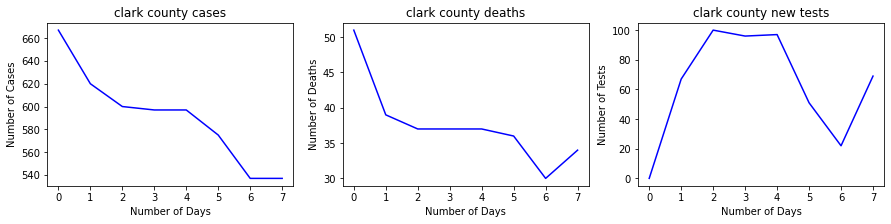

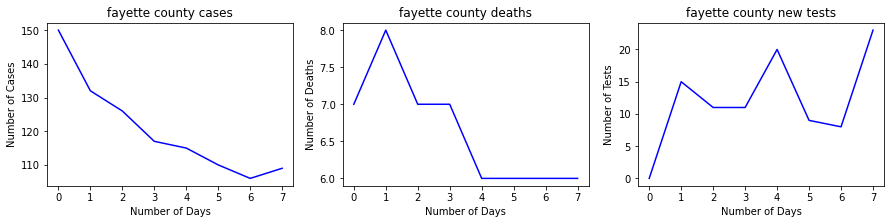

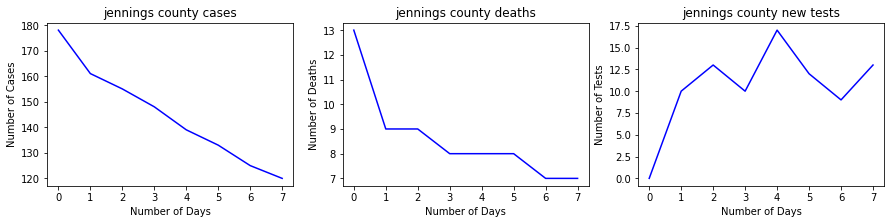

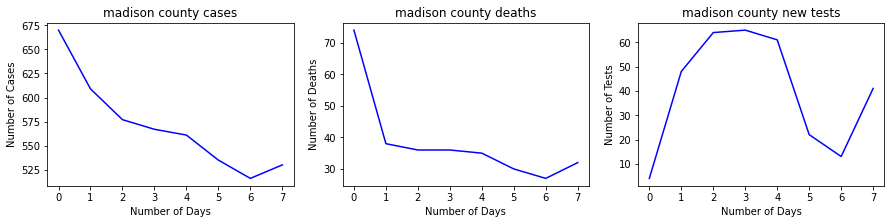

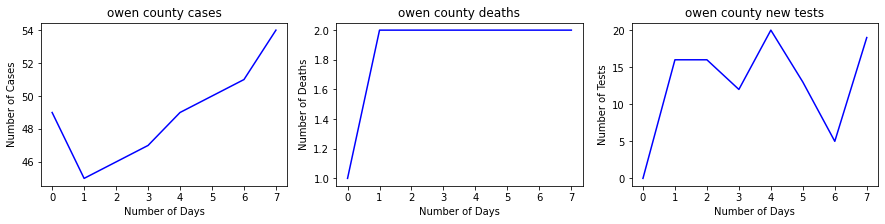

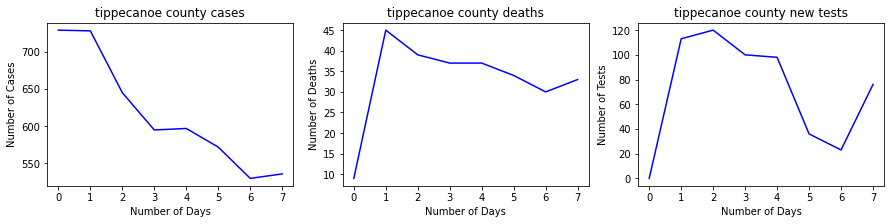

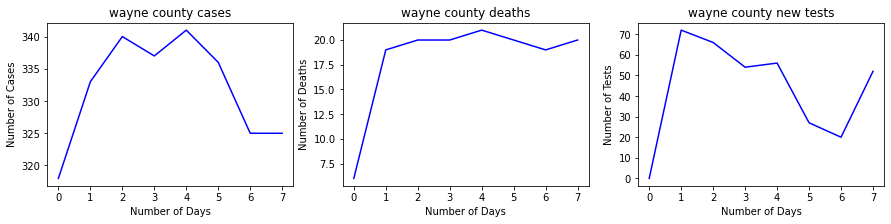

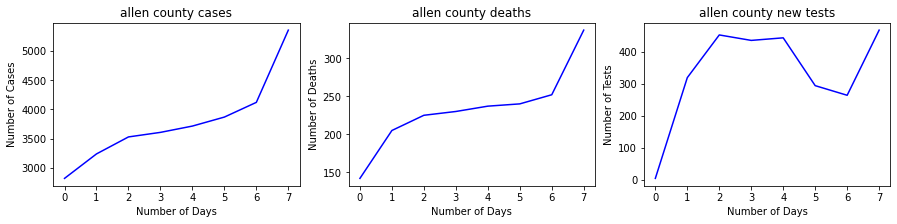

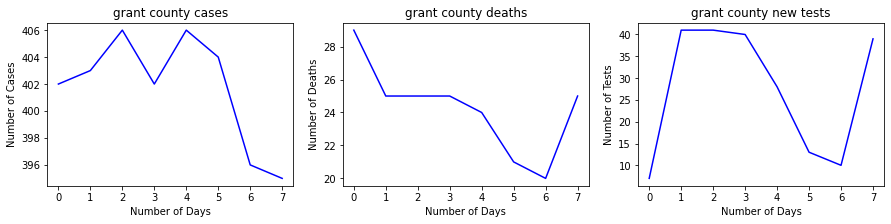

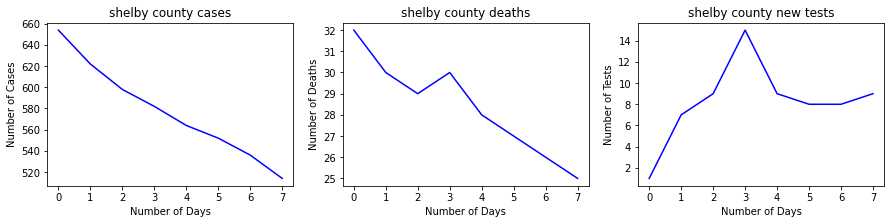

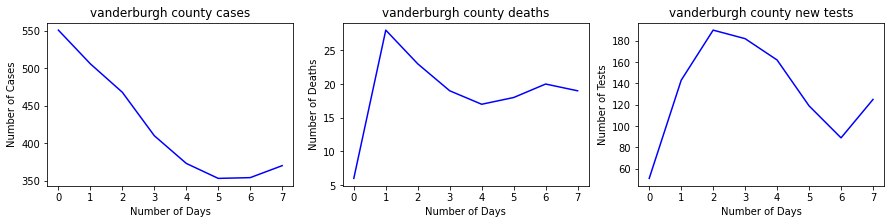

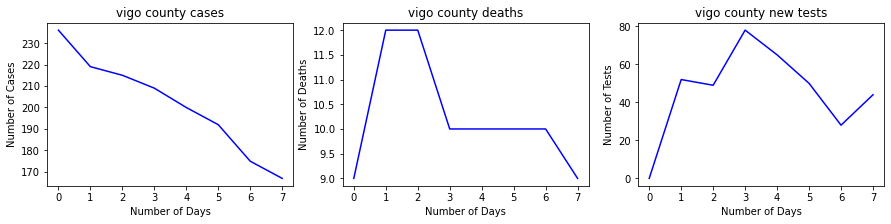

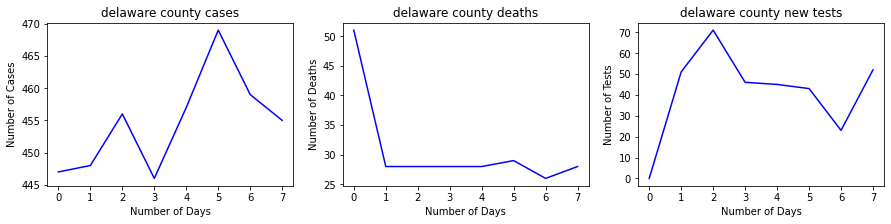

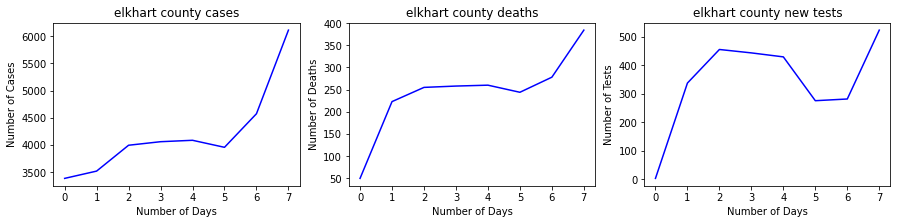

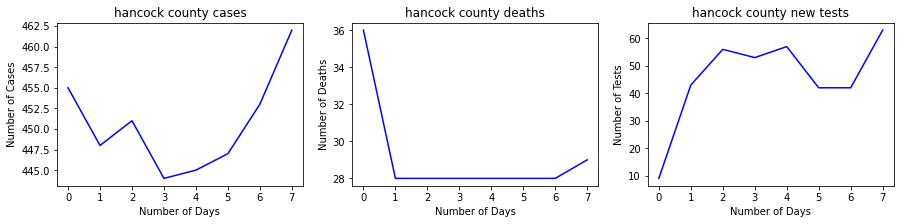

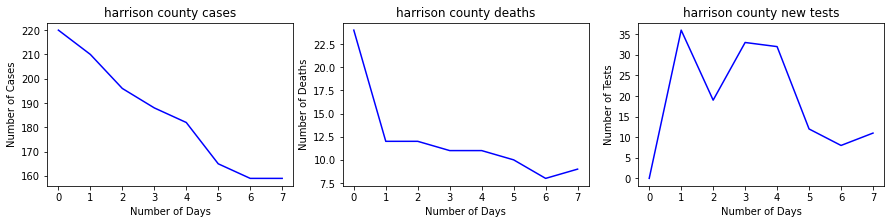

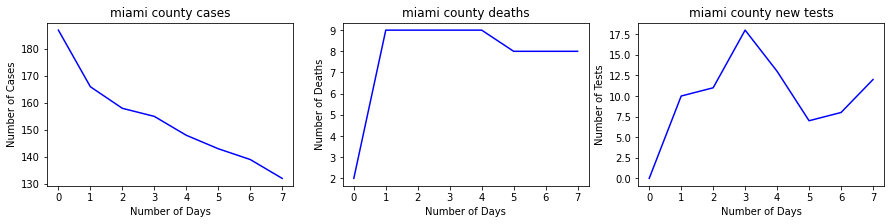

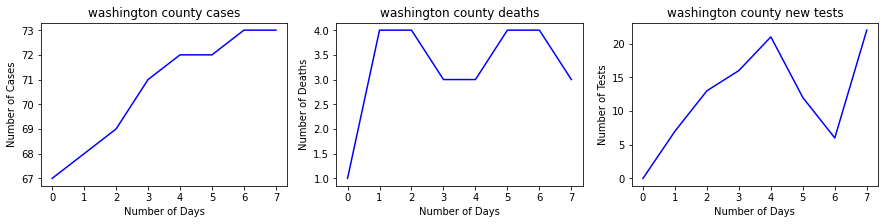

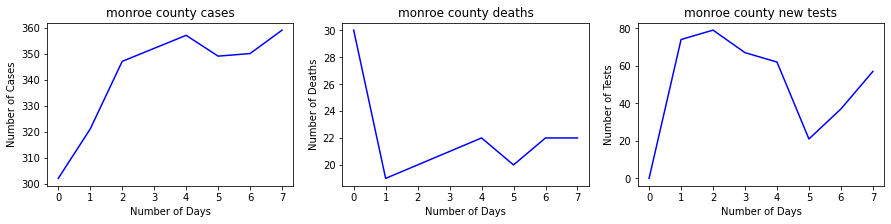

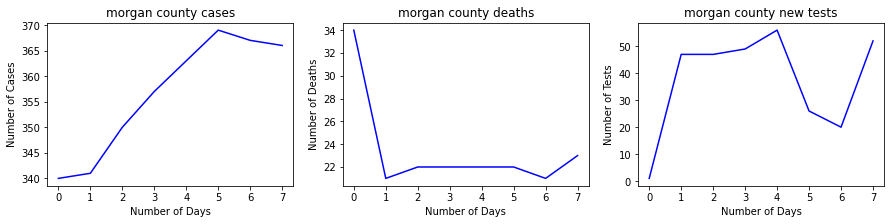

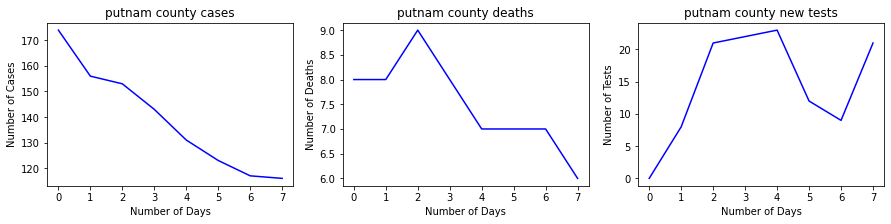

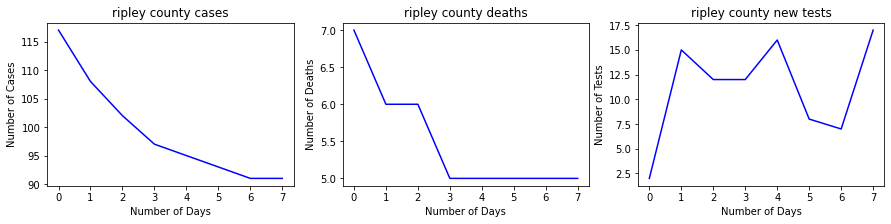

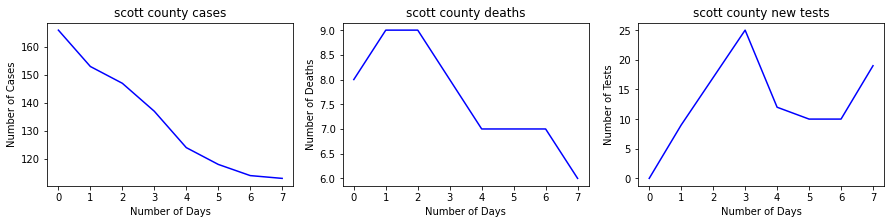

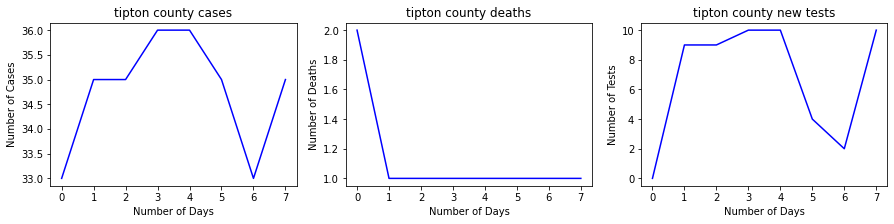

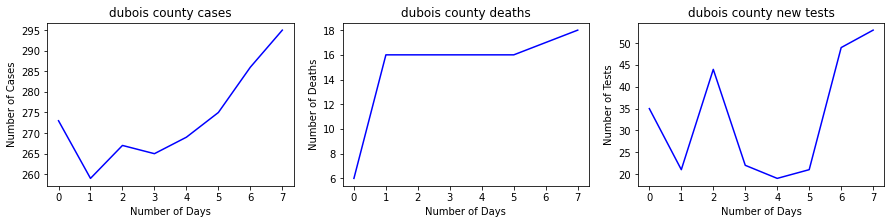

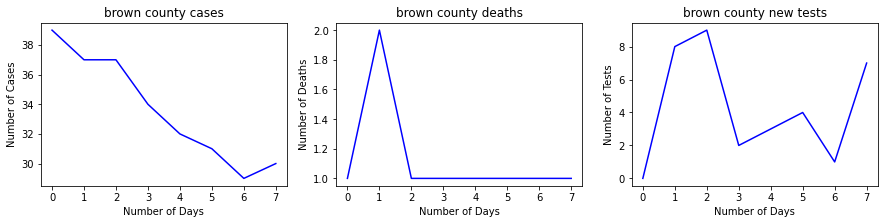

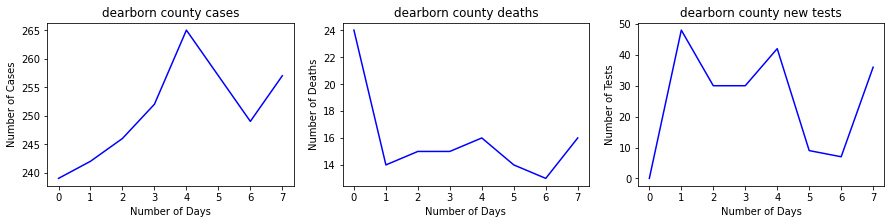

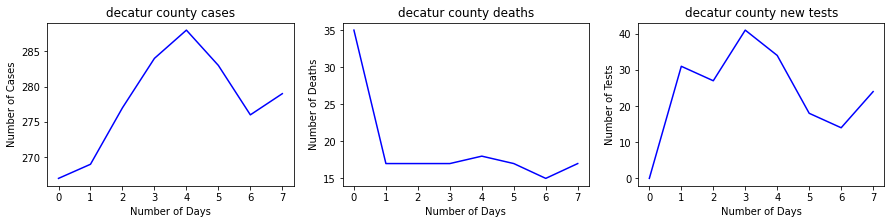

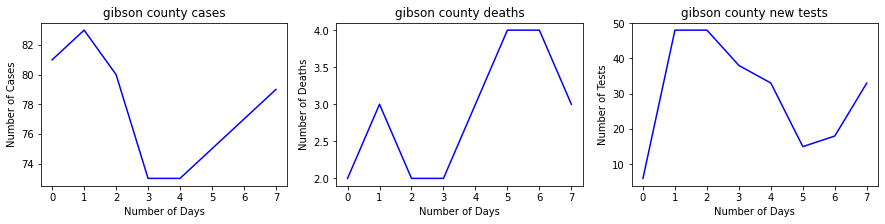

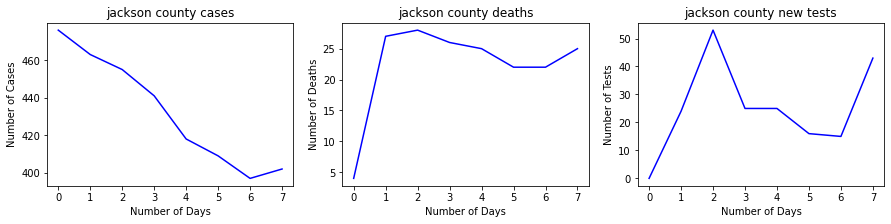

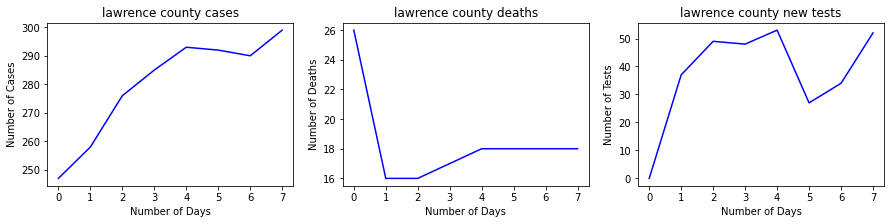

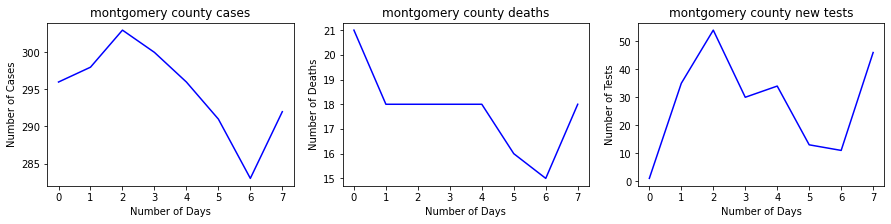

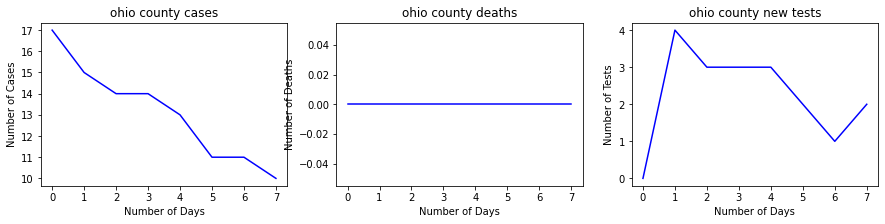

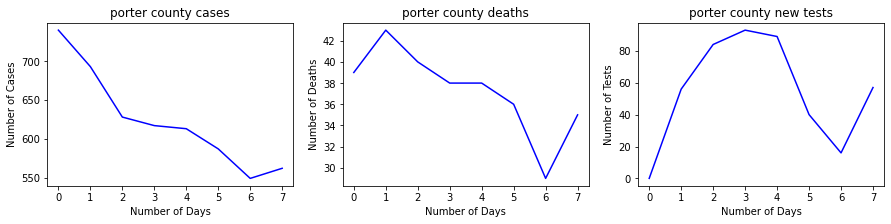

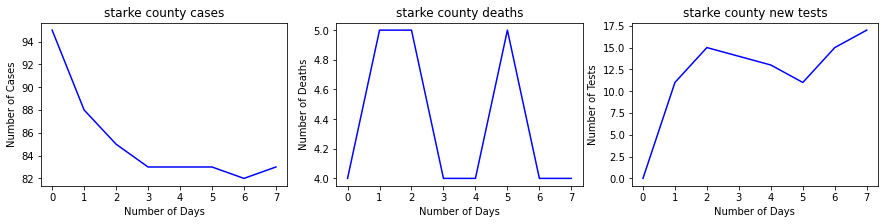

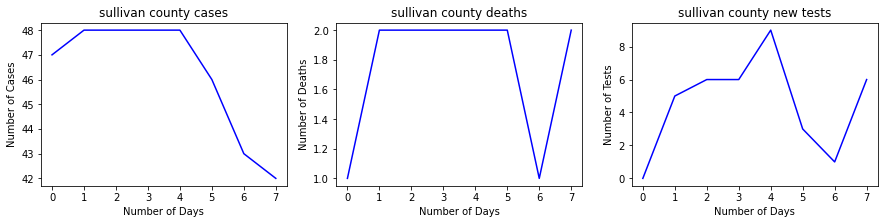

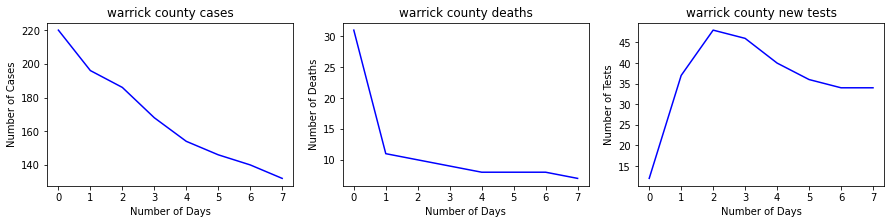

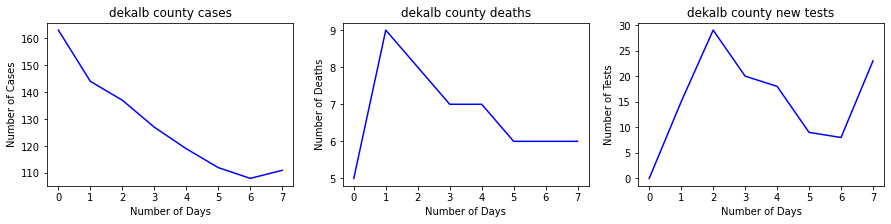

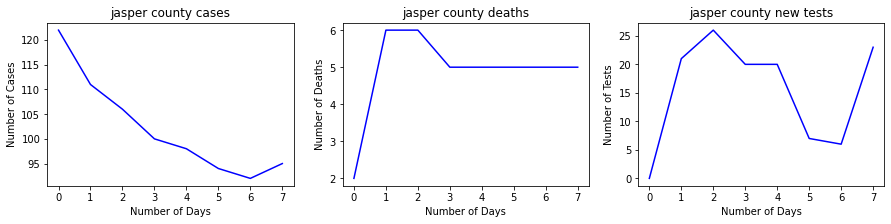

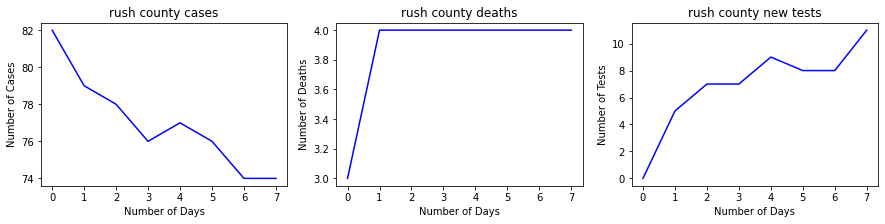

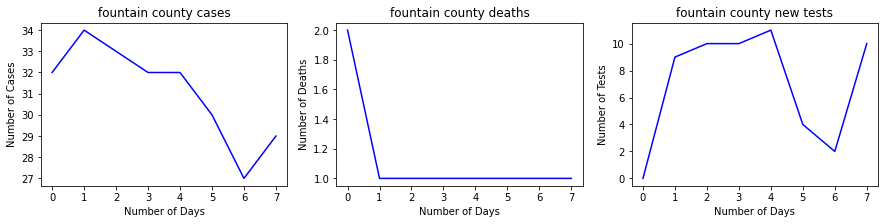

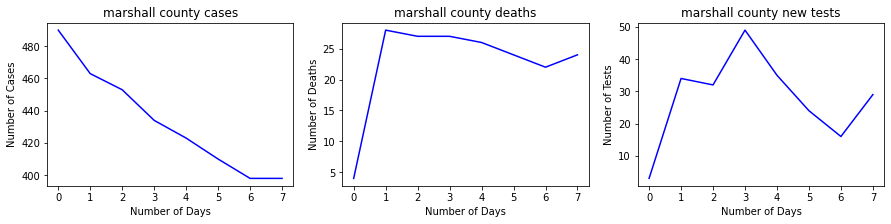

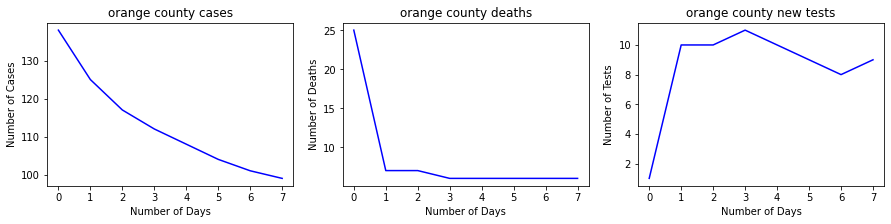

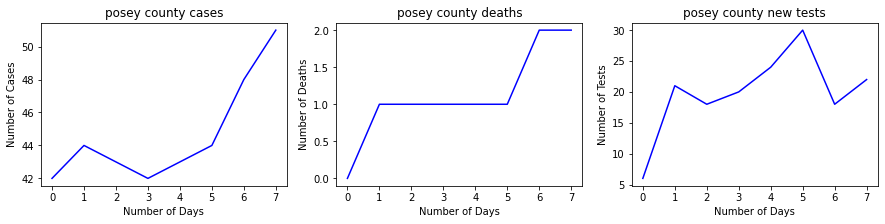

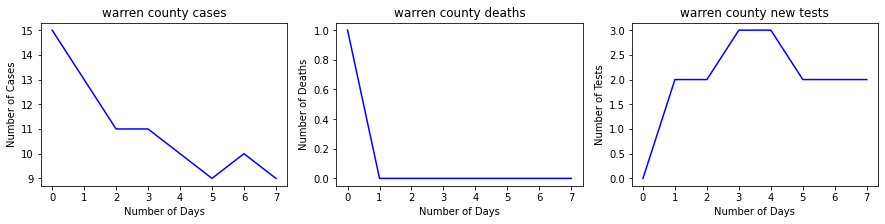

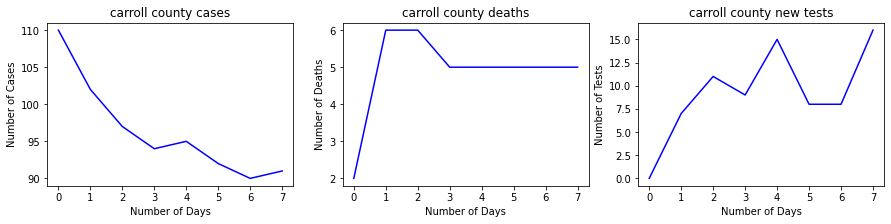

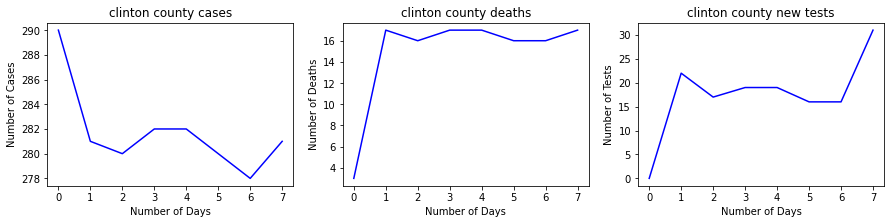

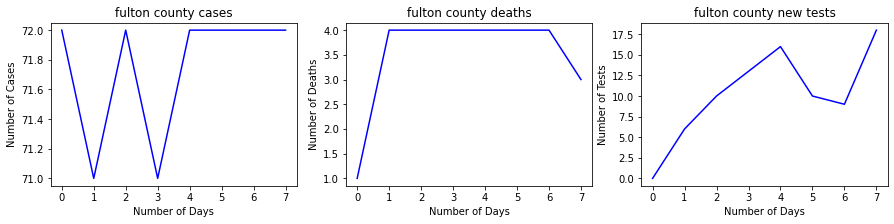

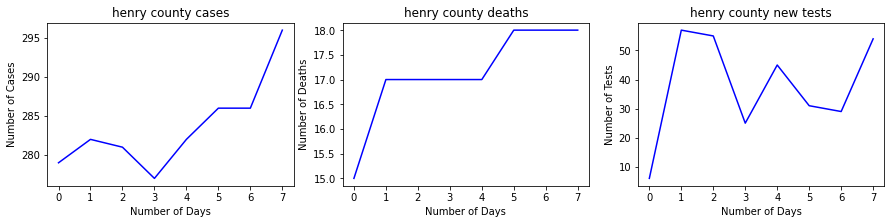

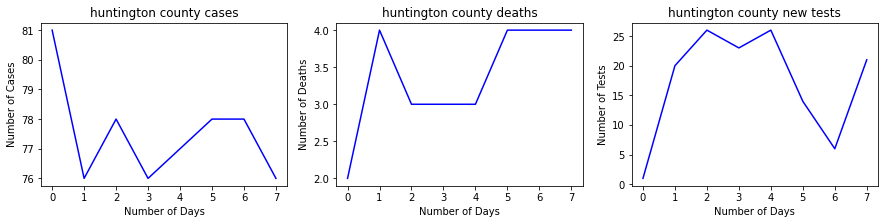

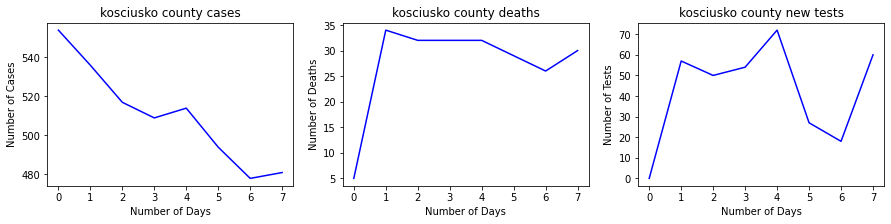

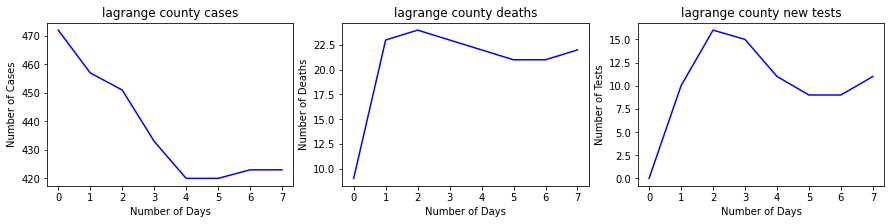

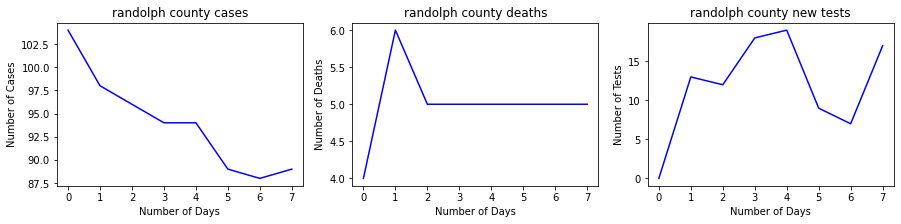

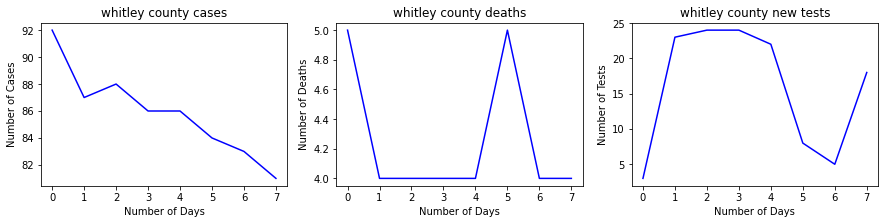

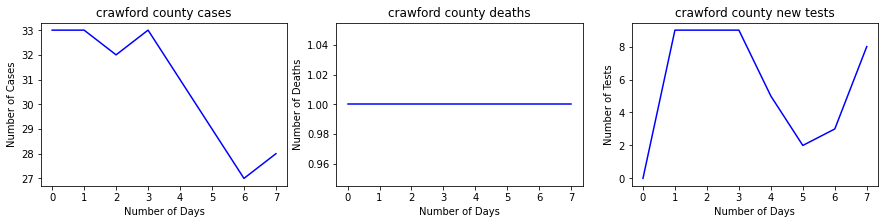

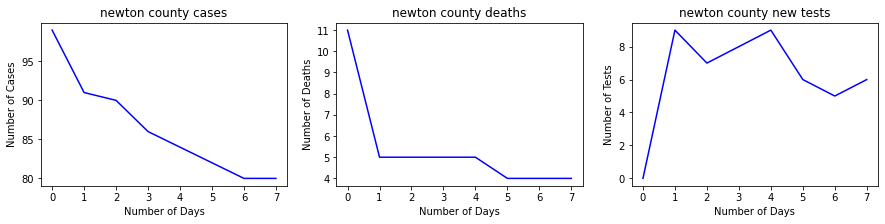

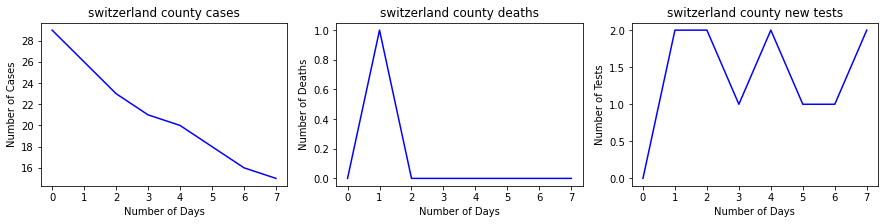

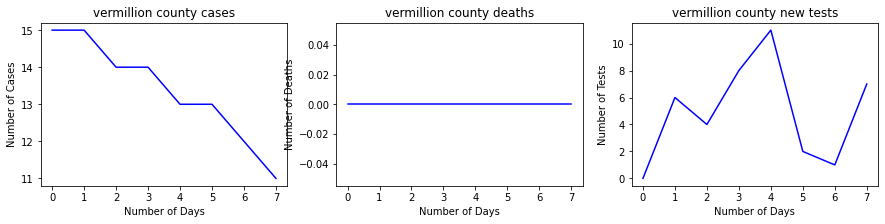

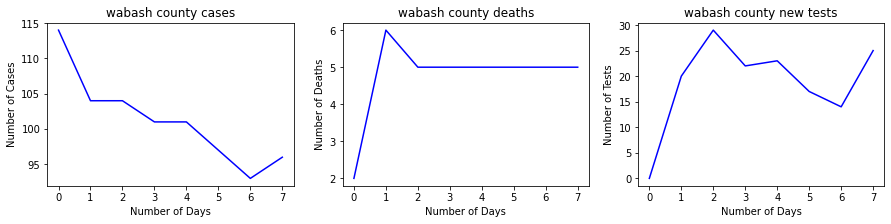

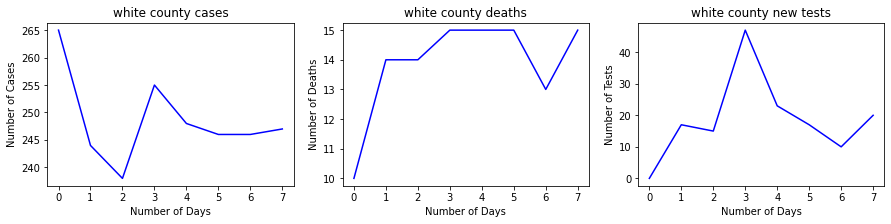

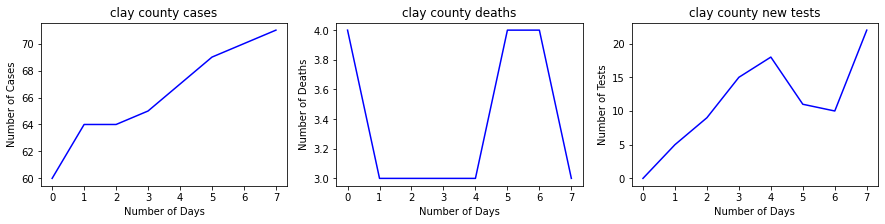

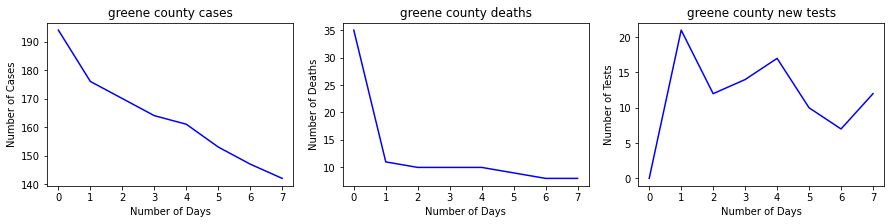

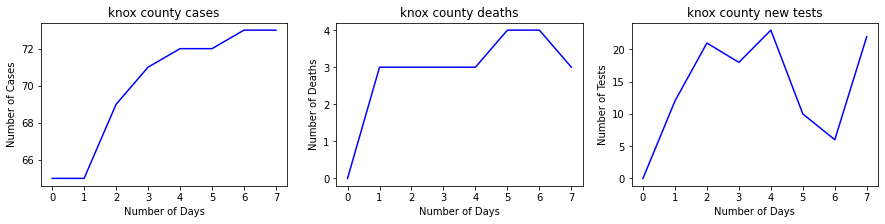

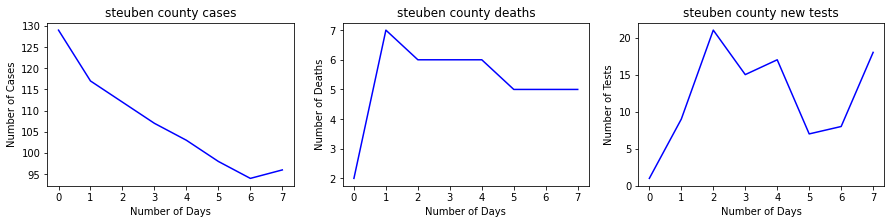

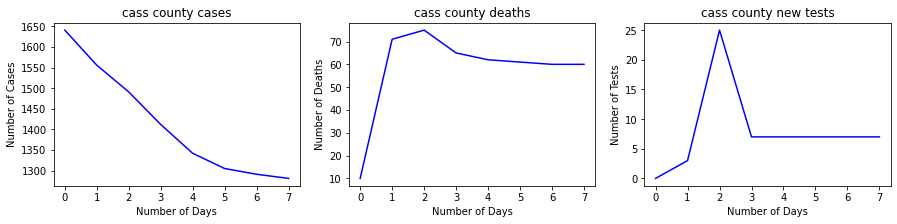

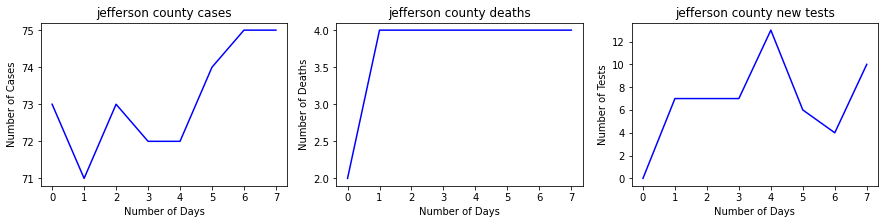

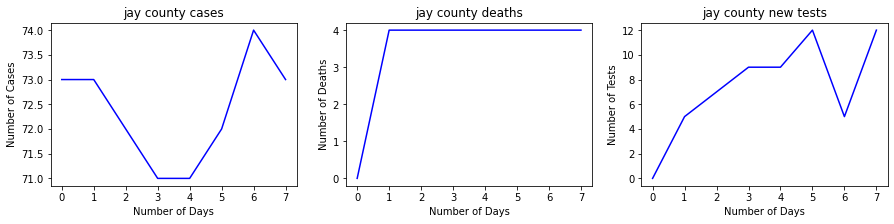

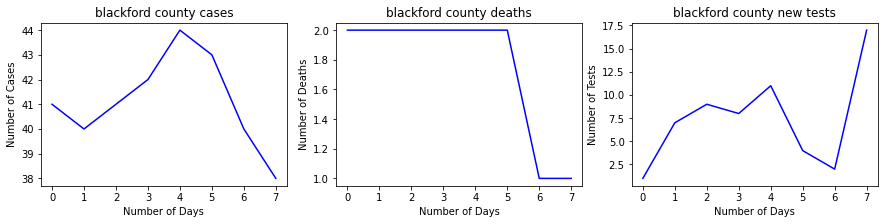

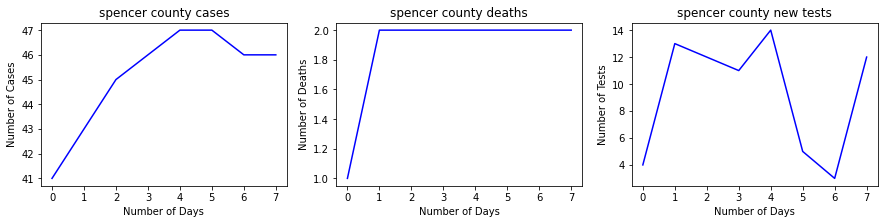

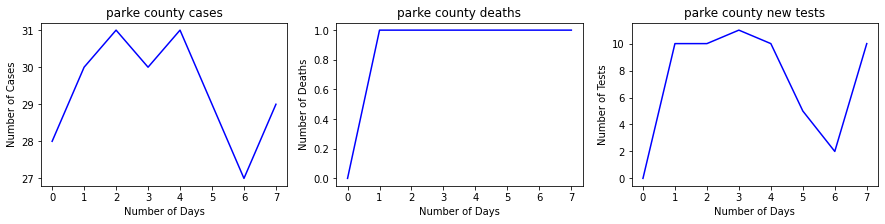

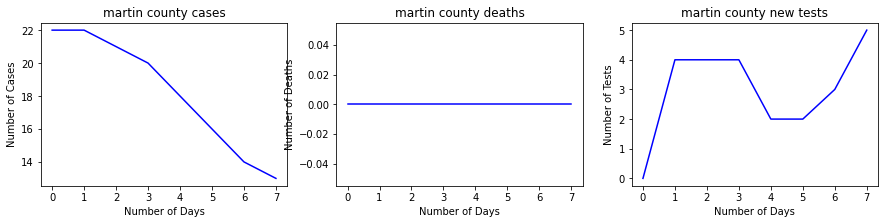

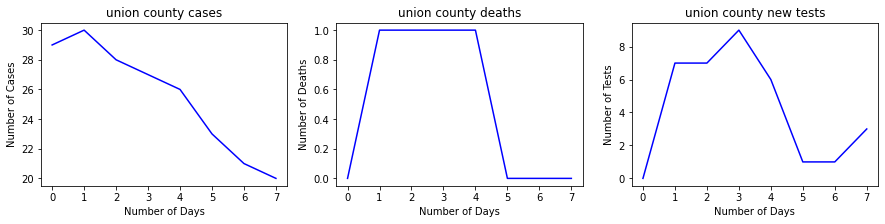

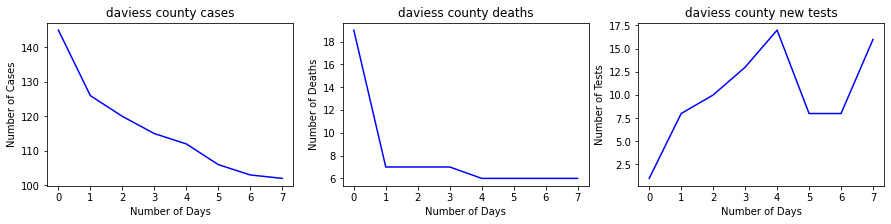

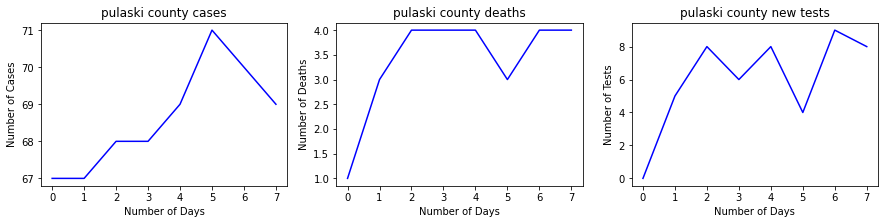

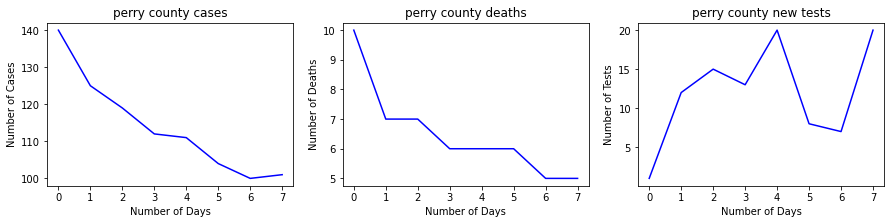

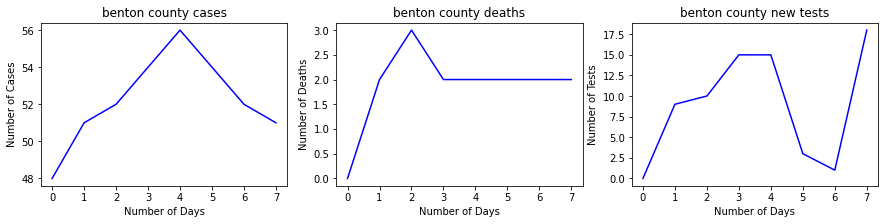

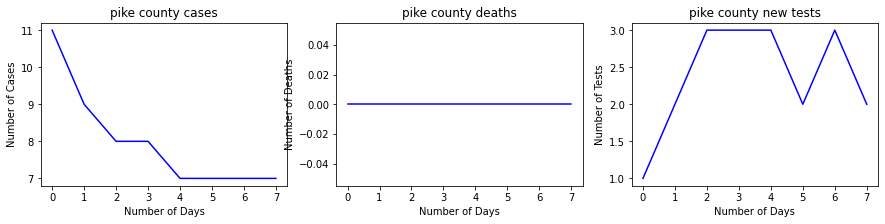

In [147]:
def Forecast(df, numOfDays = 7, formatType = 'jpg', n_len = 15):
  my_path = f"{os.getcwd()}/drive/My Drive/Techpoint/Forecasts/"
  counties = df['county'].unique()
  for county in counties:
    df5 = df[df['county']==county]
    df5 = df5.iloc[-n_len:,:]
    if df5.shape[0]<15:
      continue
    #print(county, df5.shape)
    df6 = df5[['cases', 'deaths', 'new test']].values.reshape(1,n_len,3)

    for i in range(numOfDays):
      predictedValues = new_regressor.predict(df6[:,-n_len:, :])
      for j in range(predictedValues.shape[0]):
        for k in range(predictedValues.shape[1]):
          predictedValues[j,k] = int(predictedValues[j,k])
      df6 = np.concatenate((df6, predictedValues.reshape(1,1,3)), axis = 1)
      #print(df6.shape)
    #print(df6)
    df6 = df6.reshape(df6.shape[1], df6.shape[2])
    #print(df6.shape)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
    ax1.plot(df6[-(numOfDays+1):,0], color = 'blue')
    ax1.set_title(county + ' county cases')
    ax1.set_xlabel('Number of Days')
    ax1.set_ylabel('Number of Cases')
    ax2.plot(df6[-(numOfDays+1):,1], color = 'blue')
    ax2.set_title(county + ' county deaths')
    ax2.set_xlabel('Number of Days')
    ax2.set_ylabel('Number of Deaths')
    ax3.plot(df6[-(numOfDays+1):,2], color = 'blue')
    ax3.set_title(county + ' county new tests')
    ax3.set_xlabel('Number of Days')
    ax3.set_ylabel('Number of Tests')
    if formatType == 'jpeg' or 'jpg':
        plt.savefig(my_path + str(county) + '_forecasts.jpg')
    if formatType == 'png':
        plt.savefig(my_path + str(county) + '_forecasts.png')

Forecast(combinedData, 7)

Indy State Analysis

In [ ]:
url = 'https://github.com/nytimes/covid-19-data/blob/master/us-states.csv?raw=true'

X = pd.read_csv(url)
X = X[X['state']== 'Indiana']
featureColumns = ['cases', 'deaths']
X

,date,state,fips,cases,deaths
329,2020-03-06,Indiana,18,1,0
358,2020-03-07,Indiana,18,1,0
392,2020-03-08,Indiana,18,2,0
427,2020-03-09,Indiana,18,4,0
464,2020-03-10,Indiana,18,6,0
...,...,...,...,...,...
6574,2020-06-30,Indiana,18,46740,2640
6629,2020-07-01,Indiana,18,47116,2650
6684,2020-07-02,Indiana,18,47553,2662
6739,2020-07-03,Indiana,18,48099,2682


In [ ]:
def trainTestSplit(stockData, splitValue = 0.8):
    splitIndex = int(stockData.shape[0]*splitValue)
    stockTrain = stockData[:splitIndex, :]
    stockTest = stockData[splitIndex:, :]
    return stockTrain, stockTest

def windowData(training_scaled, n_len = 5):
    x_train = []
    y_train = []
    for i in range(n_len,len(training_scaled)):
        x_train.append(training_scaled[i-n_len:i, :])
        y_train.append(training_scaled[i,:])
    x_train,y_train = np.array(x_train),np.array(y_train)
    return x_train,y_train

def getModel():
    clear_session()
    model_lstm = Sequential()
    model_lstm.add(LSTM(units = 100,return_sequences = True,input_shape = (x_train.shape[1],x_train.shape[2])))
    model_lstm.add(LSTM(units = 100,return_sequences = True))
    model_lstm.add(Dense(units = 100, activation = 'relu'))
    model_lstm.add(Dropout(0.15))
    model_lstm.add(Dense(units = 96, activation = 'relu'))
    model_lstm.add(Dropout(0.1))
    model_lstm.add(Dense(units = 32, activation = 'relu'))
    model_lstm.add(Dropout(0.05))
    model_lstm.add(Dense(units = stockData.shape[1]))
    model_lstm.compile(optimizer = 'adam',loss = 'mean_absolute_error')
    return model_lstm

In [ ]:
from random import random
from sklearn.preprocessing import MinMaxScaler

stockData = X[featureColumns]
stockData = np.array(stockData)
stockTrain, stockTest = trainTestSplit(stockData, 0.85)
print(stockTrain.shape, stockTest.shape)

sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(stockTrain)
testing_scaled = sc.fit_transform(stockTest)

x_train,y_train = windowData(training_scaled, 5)
x_test,y_test = windowData(testing_scaled, 5)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

model_lstm = getModel()
model_lstm.summary()

(102, 2) (19, 2)
(97, 5, 2) (97, 2)
(14, 5, 2) (14, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            41200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dense (Dense)                (None, 5, 100)            10100     
_________________________________________________________________
dropout (Dropout)            (None, 5, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 96)             9696      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 96)             0         
_________________________________________________________________
d

In [ ]:
model_lstm.fit(x_train,y_train,epochs = 25, batch_size = 1)

Epoch 1/25
97/97 [==============================] - 1s 9ms/step - loss: 0.0578
Epoch 2/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0727
Epoch 3/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0540
Epoch 4/25
97/97 [==============================] - 1s 5ms/step - loss: 0.0558
Epoch 5/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0547
Epoch 6/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0499
Epoch 7/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0475
Epoch 8/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0440
Epoch 9/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0574
Epoch 10/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0474
Epoch 11/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0468
Epoch 12/25
97/97 [==============================] - 1s 6ms/step - loss: 0.0489
Epoch 13/25
97/97 [==============================

In [ ]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/indyModel.h5"
model_lstm.save(path) 
#new_regressor.save(path)

In [ ]:
path = f"{os.getcwd()}/drive/My Drive/Techpoint/indyModel.h5"
new_lstmModel= load_model(path)

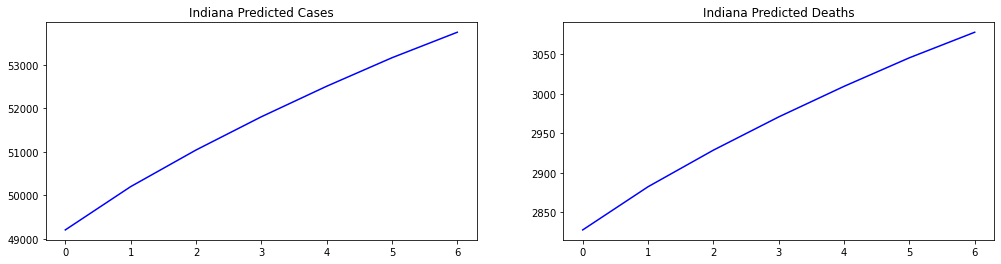

In [ ]:
def getValidation(x_test, y_test, n_len = 5, drawGraph = False):
    predictedValues = new_lstmModel.predict(x_test)
    predictedValues = predictedValues[:,-1,:]
    predictedValues = sc.inverse_transform(predictedValues)
    y_test = sc.inverse_transform(y_test)
    if drawGraph:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,4))
        ax1.plot(y_test[:,0],color = 'red', label = 'True_Values')
        ax1.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
        ax1.set_title('Indiana Cases for Validation')
        ax1.legend()
        ax2.plot(y_test[:,1],color = 'red', label = 'True_Values')
        ax2.plot(predictedValues[:,1], color = 'blue', label = 'Predicted_Values')
        ax2.set_title('Indiana Deaths for Validation')
        ax2.legend()

def getForecast(stockData, numOfDays = 7, n_len = 5):
    Forecast = np.random.randn(1,2)
    stockPred = sc.fit_transform(stockData)
    predictData = stockPred[-(n_len):,:]
    for i in range(numOfDays):
        predictData = predictData.reshape(1,predictData.shape[0],predictData.shape[1])
        valuesPred = new_lstmModel.predict(predictData[:,-5:, :])
        valuesPred = valuesPred[:,-1,:].reshape(1,-1)
        predictData = predictData[:,-n_len:, :].reshape(5,2)
        predictData = np.concatenate((predictData, valuesPred), axis = 0)
        Forecast = np.concatenate((Forecast, valuesPred), axis = 0)

    Forecast = Forecast[1:,:]
    Forecast = sc.inverse_transform(Forecast)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,4))
    ax1.plot(Forecast[:,0], color = 'blue', label = 'Predicted_Values')
    ax1.set_title('Indiana Predicted Cases')
    ax2.plot(Forecast[:,1], color = 'blue', label = 'Predicted_Values')
    ax2.set_title('Indiana Predicted Deaths')

getValidation(x_test, y_test)
getForecast(stockData)

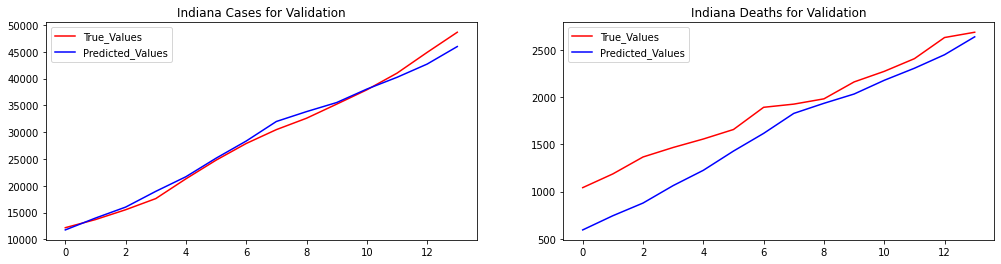

In [ ]:
getValidation(x_test, y_test, 5, True)